# Section 1.2: Round-off Errors and Computer Arithmetic

## Floating-point arithmetic

Real numbers are stored on a computer following the IEEE floating-point standard:

1. **half precision** using 16 bits (Julia type: `Float16`)
2. **single precision** using 32 bits (Julia type: `Float32`)
3. **double precision** using 64 bits (Julia type: `Float64`)

Julia also has an **arbitrary precision** floating-point data type called `BigFloat`. It is excellent if you need more **precision**, but it is also much **slower**.

## Description of IEEE double floating-point format (`Float64`)

Suppose $x$ is a floating-point number stored in the following 64-bits:

| 1 | 2 | $\cdots$ | 12 | 13 | $\cdots$ | 64 |
|:-:|:-:|:--------:|:--:|:--:|:--------:|:--:|
|$s$|$e_{10}$| $\cdots$ |$e_0$|$f_1$|$\cdots$|$f_{52}$|

- 1 bit $s$ represents the **sign**
- 11 bits $e_{10} \cdots e_{0}$ represent the **exponent**
- 52 bits $f_1 \cdots f_{52}$ represent the **fraction** (a.k.a. the mantissa or significand)

Then

$$ x = (-1)^s \left[1.f_1 \cdots f_{52}\right]_2 \times 2^{(e-1023)}.$$

Notes: 

- $x$ is **normalized** to have its first digit nonzero.
- $$e = \left[e_{10} \cdots e_{0}\right]_2 = e_{10} 2^{10} + \cdots + e_1 2^1 + e_0 2^0 \in \left[0, 2^{11}-1\right] = [0, 2047]$$
- $e = 0$ and $e = 2047$ are reserved for special floating-point values, so 

$$e \in [1, 2046]$$

- the "$-1023$" in the exponent is called the **bias**:  $e-1023 \in [-1022,1023]$ (**In the book is considered the bias exponent in $[-1023,1024]$**)
- $$\left[1.f_1 \cdots f_{52}\right]_2 = 1 + \frac{f_1}{2^1} + \frac{f_2}{2^2} + \cdots + \frac{f_{52}}{2^{52}}$$
in base $2$.

![title](Mantissa2.png)

## Example

$$
\begin{split}
x & = -[1.101101]_2 \times 2^{(1026-1023)} \\
  & = -[1.101101]_2 \times 2^{3} \\
  & = -[1101.101]_2 \\
  & = -\left(1 \cdot 8 + 1 \cdot 4 + 0 \cdot 2 + 1 \cdot 2^0 + 1 \cdot \frac{1}{2} + 0 \cdot \frac{1}{4} + 1 \cdot \frac{1}{8}\right)  \\
  & = -13.625
\end{split}
$$

In [1]:
?bits

search: bits isbits flipbits! bitbroadcast bitrand BitArray BitVector BitMatrix



```
bits(n)
```

A string giving the literal bit representation of a number.

```jldoctest
julia> bits(4)
"0000000000000000000000000000000000000000000000000000000000000100"

julia> bits(2.2)
"0100000000000001100110011001100110011001100110011001100110011010"
```


In [2]:
s = bits(-13.625)
s[1], s[2:12], s[13:64]

('1', "10000000010", "1011010000000000000000000000000000000000000000000000")

## Example

Even if a number can be represented exactly in base-10 with a finite number of digits, it may require an infinite number of digits in base-2.

$$
0.1 = \left[0.000110011001\ldots\right]_2 = \left[1.\overline{1001}\right]_2 \times 2^{-4}
$$

Therefore, $0.1$ cannot be represented exactly as a floating-point number.

In [11]:
s = bits(0.1)
s[1], s[2:12], s[13:64]

('0',"01111111011","1001100110011001100110011001100110011001100110011010")

## Limits of floating-point numbers

- **Largest** `Float64` $= \left(2 - 2^{-52}\right) \times 2^{1023} \approx 2 \times 10^{308}$
- **Smallest positive normalized** `Float64` $= 2^{-1022} \approx 2 \times 10^{-308}$

In [3]:
?realmax

search: realmax realmin readdlm ReadOnlyMemoryError



```
realmax(T)
```

The highest finite value representable by the given floating-point DataType `T`.

```jldoctest
julia> realmax(Float16)
Float16(6.55e4)

julia> realmax(Float32)
3.4028235f38
```


In [4]:
# Experiment with realmax
x = realmax(Float64)

1.7976931348623157e308

In [2]:
s = bits(x)
s[1], s[2:12], s[13:64]

('0',"11111111110","1111111111111111111111111111111111111111111111111111")

In [3]:
2x

Inf

In [4]:
(x + 1) - x

0.0

In [2]:
?floatmin

search: floatmin floatmax



```
floatmin(T)
```

The smallest in absolute value non-subnormal value representable by the given floating-point DataType `T`.


In [3]:
# Experiment with realmin
x = floatmin(Float64)

2.2250738585072014e-308

In [5]:
s = bitstring(x)
s[1], s[2:12], s[13:64]

('0', "00000000001", "0000000000000000000000000000000000000000000000000000")

In [6]:
(x + 1.0) - 1.0

0.0

## Other special floats

- `0.0` and `-0.0`: $$e_{10} \cdots e_0 = 0 \cdots 0 \quad \text{and} \quad f_1 \cdots f_{52} = 0 \cdots 0$$
- `Inf` and `-Inf`: $$e_{10} \cdots e_0 = 1 \cdots 1 \quad \text{and} \quad f_1 \cdots f_{52} = 0 \cdots 0$$
- `NaN` (not-a-number): $$e_{10} \cdots e_0 = 1 \cdots 1 \quad \text{and} \quad f_1 \cdots f_{52} \neq 0$$

From [Julia Manual: Mathematical Operations and Elementary Functions](http://julia.readthedocs.org/en/latest/manual/mathematical-operations/):

- `Inf` is equal to itself and greater than everything else except `NaN`.
- `-Inf` is equal to itself and less then everything else except `NaN`.
- `NaN` is not equal to, not less than, and not greater than anything, including itself.

In [7]:
# Experiment with 0.0, -0.0, Inf, -Inf, and NaN

1.0/0.0

Inf

In [10]:
sqrt(-1.0)

DomainError: DomainError with -1.0:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [11]:
sqrt(-1.0 + 0.0im)

0.0 + 1.0im

In [11]:
-0.0 < 0.0

false

In [13]:
bitstring(-0.0)

"1000000000000000000000000000000000000000000000000000000000000000"

In [15]:
bitstring(0.0)

"0000000000000000000000000000000000000000000000000000000000000000"

In [16]:
-0.0 == 0.0

true

In [17]:
-0.0 === 0.0

false

In [18]:
NaN == NaN

false

In [19]:
NaN === NaN

true

In [22]:
bitstring(NaN)

"0111111111111000000000000000000000000000000000000000000000000000"

In [23]:
-1.0/0.0

-Inf

In [24]:
1.0/-0.0

-Inf

In [25]:
0.0/0.0

NaN

In [26]:
0.0/Inf

0.0

In [27]:
Inf/0.0

Inf

In [28]:
Inf/Inf

NaN

In [29]:
NaN + 1.0

NaN

## Machine epsilon `eps(Float64)` and the unit roundoff $\eta$

- `1.0 + eps(Float64)` is the **first** `Float64` that is **larger** than `1.0`

$$\mathtt{eps(Float64)} = 2^{-52} \approx 2.2 \times 10^{-16}$$

- $\eta = $ `eps(Float64)/2.0` is the largest possible **relative error** due to roundoff

$$\eta = 2^{-53} \approx 1.1 \times 10^{-16}$$

In [31]:
?eps

search: eps @elapsed expanduser escape_string setprecision peakflops



```
eps(::Type{T}) where T<:AbstractFloat
eps()
```

Return the *machine epsilon* of the floating point type `T` (`T = Float64` by default). This is defined as the gap between 1 and the next largest value representable by `typeof(one(T))`, and is equivalent to `eps(one(T))`.  (Since `eps(T)` is a bound on the *relative error* of `T`, it is a "dimensionless" quantity like [`one`](@ref).)

# Examples

```jldoctest
julia> eps()
2.220446049250313e-16

julia> eps(Float32)
1.1920929f-7

julia> 1.0 + eps()
1.0000000000000002

julia> 1.0 + eps()/2
1.0
```

---

```
eps(x::AbstractFloat)
```

Return the *unit in last place* (ulp) of `x`. This is the distance between consecutive representable floating point values at `x`. In most cases, if the distance on either side of `x` is different, then the larger of the two is taken, that is

```
eps(x) == max(x-prevfloat(x), nextfloat(x)-x)
```

The exceptions to this rule are the smallest and largest finite values (e.g. `nextfloat(-Inf)` and `prevfloat(Inf)` for [`Float64`](@ref)), which round to the smaller of the values.

The rationale for this behavior is that `eps` bounds the floating point rounding error. Under the default `RoundNearest` rounding mode, if $y$ is a real number and $x$ is the nearest floating point number to $y$, then

$$
|y-x| \leq \operatorname{eps}(x)/2.
$$

# Examples

```jldoctest
julia> eps(1.0)
2.220446049250313e-16

julia> eps(prevfloat(2.0))
2.220446049250313e-16

julia> eps(2.0)
4.440892098500626e-16

julia> x = prevfloat(Inf)      # largest finite Float64
1.7976931348623157e308

julia> x + eps(x)/2            # rounds up
Inf

julia> x + prevfloat(eps(x)/2) # rounds down
1.7976931348623157e308
```

---

```
eps(::DateTime) -> Millisecond
eps(::Date) -> Day
eps(::Time) -> Nanosecond
```

Returns `Millisecond(1)` for `DateTime` values, `Day(1)` for `Date` values, and `Nanosecond(1)` for `Time` values.


In [30]:
# Experiment with eps
ϵ = eps()

2.220446049250313e-16

In [32]:
1.0 + ϵ == 1.0

false

In [33]:
1.0 + ϵ/2.0 == 1.0

true

In [34]:
nextfloat(1.0) - 1.0

2.220446049250313e-16

## Roundoff error example

Suppose we are using a base-10 floating-point system with 4 significant digits, using `RoundNearest`:

$$
\begin{split}
\left( 1.112 \times 10^1 \right) \times \left( 1.112 \times 10^2 \right)
& = 1.236544 \times 10^3 \\
& \rightarrow 1.237 \times 10^3 = 1237
\end{split}
$$

The **absolute error** is $1237 - 1236.544 = 0.456$.

The **relative error** is $$\frac{0.456}{1236.544} \approx 0.0004 = 0.04 \%$$

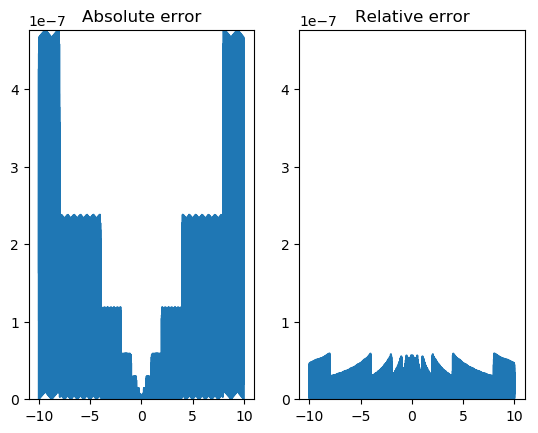

In [53]:
# Study the effect of roundoff error by plotting 
# the absolute error and relative error of converting 
# Float64 numbers to Float32

η = eps(Float32)/2.0

x = Array(range(-10.0,stop=10.0,length=10000))
y = map(Float32, x)     # Convert x to Float32
abserr = broadcast(abs, x-y) # Absolute roundoff errors
relerr = abserr./broadcast(abs, x) # Relative roundoff errors

using PyPlot

subplot(1, 2, 1)
plot(x, abserr)
ylim(0.0, maximum(abserr))
title("Absolute error")

subplot(1, 2, 2)
plot(x, relerr)
# plot(x, η*fill(x), "r") creates a red line that should be horizontal, but isn't currently
ylim(0.0, maximum(abserr))
title("Relative error");

The default rounding mode is `RoundNearest` (round to the nearest floating-point number). This implies that

$$ \frac{|x - \mathrm{fl}(x)|}{|x|} \leq \eta.$$

## Roundoff error accumulation

When performing arithmetic operations on floats, extra **guard digits** are used to ensure **exact rounding**. This guarantees that the relative error of a floating-point operation (**flop**) is small. More precisely, for floating-point numbers $x$ and $y$, we have

$$
\begin{split}
\mathrm{fl}(x \pm y) &= (x \pm y)(1 + \varepsilon_1) \\
\mathrm{fl}(x \times y) &= (x \times y)(1 + \varepsilon_2) \\
\mathrm{fl}(x \div y) &= (x \div y)(1 + \varepsilon_3) \\
\end{split}
$$

where $|\varepsilon_i| \leq \eta$, for $i = 1,2,3$, where $\eta$ is the unit roundoff.

Although the relative error of each flop is small, it is possible to have the roundoff error accumulate and create significant error in the final result. If $E_n$ is the error after $n$ flops, then:

- **linear roundoff error accumulation** is when $E_n \approx c_0 n E_0$
- **exponential roundoff error accumulation** is when $E_n \approx c_1^n E_0$, for some $c_1 > 1$

In general, linear roundoff error accumulation is unavoidable. On the other hand, exponential roundoff error accumulation is not acceptable and is an indication of an **unstable algorithm**. 

## General advice

1. Adding $x + y$ when $|x| \gg |y|$ can cause the information in $y$ to be 'lost' in the summation.

2. Dividing by very small numbers or multiplying by very large numbers can **magnify error**.

3. Subtracting numbers that are almost equal produces **cancellation error**.

4. An **overflow** occurs when the result is too large in magnitude to be representable as a float. Result will become either `Inf` or `-Inf`. Overflows should be avoided.

4. An **underflow** occurs when the result is too small in magnitude to be representable as a float. Result will become either `0.0` or `-0.0`.


## Example (summation order)

This next example shows that summation order can make a difference. We will compute

$$
s = \sum_{n = 1}^{1,000,000} \frac{1}{n}
$$

in three different ways:

In [46]:
# Sum from largest to smallest
s1 = 0.0
for n = 1:1e8
    s1 += 1.0/n
end
s1

18.997896413852555

In [47]:
# Sum from smallest to largest
s2 = 0.0
for n = 1e8:-1:1
    s2 += 1.0/n
end
s2

18.997896413853447

In [48]:
# Sum largest to smallest and so on
s3 = 0.0
for n = 1:(1e8)/2
    s3 += 1.0/n + 1/(1e8-n+1)
end
s3

18.99789641384885

In [49]:
abs(s1 - s2)/s1

4.693841433563712e-14

In [50]:
abs(s1 - s3)/s1

1.9504687709987854e-13

## Example (cancellation error)

Show that 

$$
\ln\left( x - \sqrt{x^2-1} \right) = -\ln\left( x + \sqrt{x^2-1} \right).
$$

Which formula is more suitable for numerical computation?

In [51]:
# Experiment with both formulas
x = 1e8/2
f1 = log(x - sqrt(x^2 - 1))
f2 = -log(x + sqrt(x^2 - 1))

println(f1)
println(f2)

-18.714973875118524
-18.420680743952367


In [52]:
abs(f1 - f2)/abs(f1)

0.015725008922262945

## Example (four-digit rounding arithmetic)
The quadratic formula to find the roots of 
### $$x^2+bx+c=0\qquad \mbox{are}\qquad x_1=\frac{-b+\sqrt{b^2-4c}}{2} \quad \mbox{and} \quad x_2=\frac{-b-\sqrt{b^2-4c}}{2}.$$
Using four-digit rounding arithmetic; consider this formula applied to the equation 
### $$x^2+62.10x+1=0$$ 
whose roots are
### $$x_1=-0.01610723 \quad \mbox{and} \quad x_2=-62.08390.$$ 
Here, $b$ and $\sqrt{b^2-4c}$ are nearly equal numbers, since $b^2$ is much larger than $4a$. So,
### $$\sqrt{b^2-4c}=\sqrt{(62.10)^2-(4.000)(1.000)}=\sqrt{3856-4.000}=\sqrt{3852}=62.06$$
and 
### $$\mathrm{fl}(x_1)=\frac{-62.10+62.06}{2}=-0.02000,$$
a poor approximation of $x_1=-0.01610723$ with **relative error** 
### $$2.4\times 10^{-1}.$$
To obtain a more accurate four-digit rounding approximation for $x_1$, we change the quadratic formula by rationalizing the numerator:
### $$x_1=\frac{-b+\sqrt{b^2-4c}}{2}\left(\frac{-b-\sqrt{b^2-4c}}{-b-\sqrt{b^2-4c}}\right)=\frac{-2c}{b+\sqrt{b^2-4c}}.$$
In this case: 
### $$\mathrm{fl}(x_1)=\frac{-2.000}{62.10+62.06}=\frac{-2.000}{124.2}=-0.01610,$$ 
which has the small **relative error** 
### $$6.2\times 10^{-4}.$$
However, this rationalization technique can lead the large **relative error**  
### $$1.9\times 10^{-1}.$$ 
for $\mathrm{fl}(x_2)$. Note that the formula 
### $$x_2=\frac{-2c}{b-\sqrt{b^2-4c}} \qquad \mbox{and} \qquad \mathrm{fl}(x_2)=-50.00.$$
The **absolute error** is $12$!!! 

## $$
\mbox{The lesson: Think before you compute!}
$$

Accuracy loss due to round-off error can also be reduced by reduce calculations.

## Example (evaluate a polynomial): 
Evaluate $f(x)= x^3 − 6.1x^2 + 3.2x + 1.5$ at $x = 4.71$ using three-digit arithmetic.

**Exact:** $$f (4.71) = 104.487111 − 135.32301 + 15.072 + 1.5 = −14.263899.$$

**Three-digit (rounding)**: $$f (4.71) = ((105. - 135.) + 15.1) + 1.5 = −13.4.$$

An alternative approach is: (**Nested or Ruffini Algorithm**)

$$f(x)=x^3 −6.1x^2 +3.2x+1.5=((x−6.1)x+3.2)x+1.5.$$
Using **three-digit rounding** arithmetic now produces

$$\begin{align}f (4.71) &= ((4.71 - 6.1)4.71 + 3.2)4.71 + 1.5 \\&= ((−1.39)(4.71) + 3.2)4.71 + 1.5 \\&= (-6.55 + 3.2)4.71 + 1.5 \\&= (-3.35)4.71 + 1.5 \\&= −15.8 + 1.5\\ &= -14.3.\end{align}$$